# Notebook for Model Evaluation

## Create Predictions

In [1]:
from datasets import load_dataset

# Load dataset
ds = load_dataset("imagefolder", data_dir="dataset", split="train")
ds = ds.train_test_split(test_size=0.2, seed=512)
labels = ds['train'].features['label'].names

c:\Users\Dylan\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Resolving data files: 100%|██████████| 2527/2527 [00:00<00:00, 66431.04it/s]


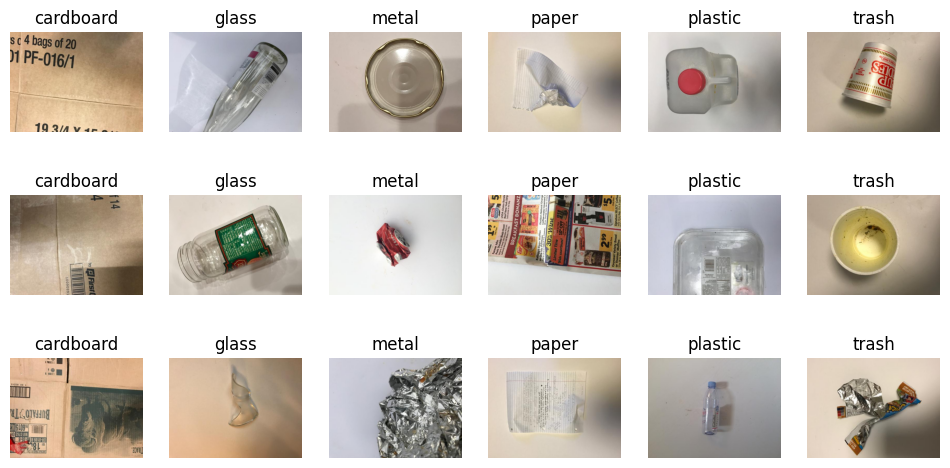

In [2]:
# Create visual for dataset

# Load three images from each label and display them in grid
import matplotlib.pyplot as plt
import numpy as np
import random

# Create figure
n = len(labels)
width = 3
fig, axs = plt.subplots(width, n, figsize=(12, 6))
axs = axs.flatten()

# Loop through labels
for i, label in enumerate(labels):
    # Get three random images from label
    idx = random.sample(ds['train'].filter(lambda x: x['label'] == i)['image'], 3)
    # Display images
    for j, img in enumerate(idx):
        axs[j*n+i].imshow(np.array(img))
        axs[j*n+i].axis('off')
        axs[j*n+i].set_title(label)

# Show figure
plt.show()

In [3]:
# Load model (change this to switch model being evaluated)
model_name = "vit"

from transformers import AutoImageProcessor, AutoModelForImageClassification, AutoProcessor, AutoModel
import torch

if model_name == "vit":
    processor = AutoImageProcessor.from_pretrained("vit-base-trash")
    model = AutoModelForImageClassification.from_pretrained("vit-base-trash").to("cuda")
elif model_name == "resnet":
    processor = AutoImageProcessor.from_pretrained("resnet-50-trash")
    model = AutoModelForImageClassification.from_pretrained("resnet-50-trash").to("cuda")
elif model_name == "clip-trash":
    processor = AutoProcessor.from_pretrained("clip-trash-s2")
    model = AutoModel.from_pretrained("clip-trash-s2").to("cuda")
elif model_name == "clip-base":
    processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch32")
    model = AutoModel.from_pretrained("openai/clip-vit-base-patch32").to("cuda")

In [4]:
import numpy as np

# Caption map for CLIP model
caption_map = {
    "cardboard": "a photo of cardboard",
    "glass": "a photo of glass",
    "metal": "a photo of metal",
    "paper": "a photo of paper",
    "plastic": "a photo of plastic",
    "trash": "a photo of trash"
}
captions = [caption_map[label] for label in labels]

# Process images and predict
def predict_images(batch):
    if model_name == "clip-trash" or model_name == "clip-base":
        inputs = processor(text=captions, images=batch['image'], return_tensors="pt", padding=True)
        with torch.no_grad():
            outputs = model(**inputs.to("cuda"))
        batch['pred'] = np.argmax(outputs.logits_per_image.detach().cpu().numpy(), axis=1)
    else:
        inputs = processor(images=batch['image'], return_tensors="pt", padding=True)
        with torch.no_grad():
            outputs = model(**inputs.to("cuda"))
        batch['pred'] = np.argmax(outputs.logits.detach().cpu().numpy(), axis=1)
    return batch

train_preds = ds['train'].map(predict_images, batched=True, batch_size=32).with_format("numpy")
test_preds = ds['test'].map(predict_images, batched=True, batch_size=32).with_format("numpy")

## Evaluate Predictions

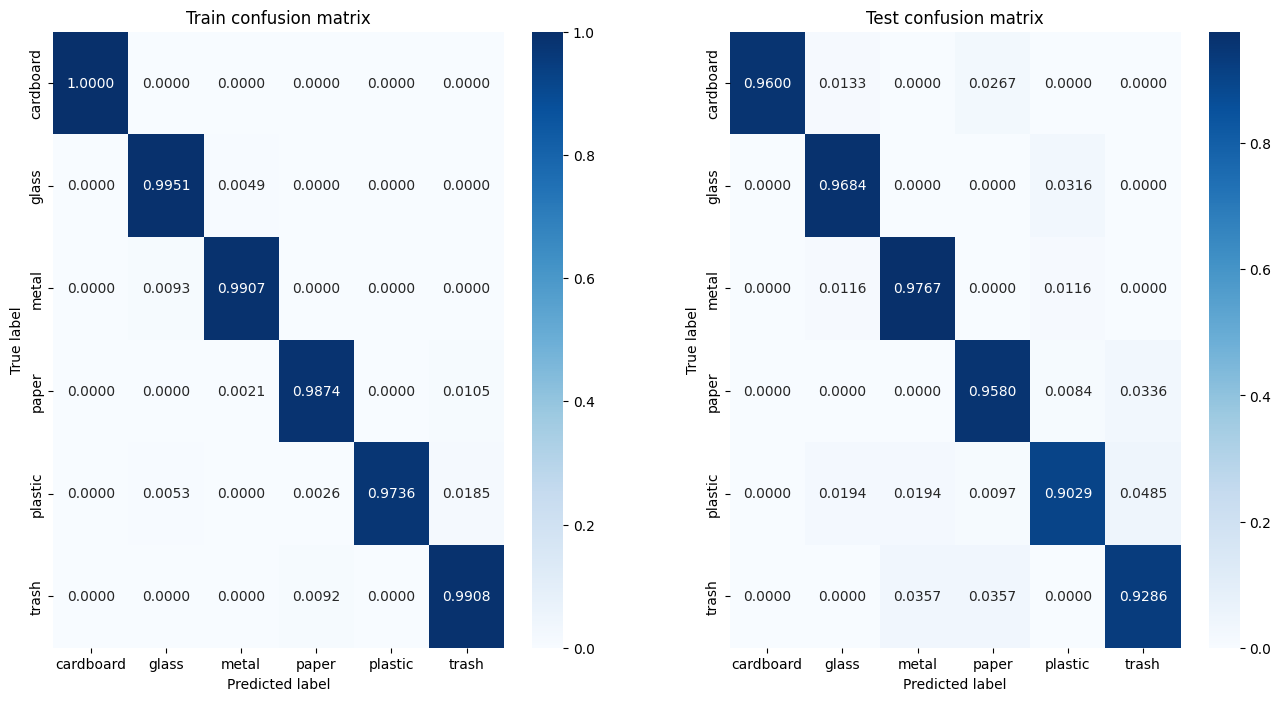

In [5]:
# Calculate confusion matrix
from sklearn.metrics import confusion_matrix

train_cm = confusion_matrix(train_preds['label'], train_preds['pred'])
test_cm = confusion_matrix(test_preds['label'], test_preds['pred'])
train_cm_percent = train_cm / np.sum(train_cm, axis=1, keepdims=True)
test_cm_percent = test_cm / np.sum(test_cm, axis=1, keepdims=True)

# Plot confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(16, 8))
sns.heatmap(train_cm_percent, annot=True, xticklabels=labels, yticklabels=labels, ax=ax[0], fmt='.4f', cmap='Blues')
sns.heatmap(test_cm_percent, annot=True, xticklabels=labels, yticklabels=labels, ax=ax[1], fmt='.4f', cmap='Blues')
ax[0].set_title("Train confusion matrix")
ax[1].set_title("Test confusion matrix")
ax[0].set_xlabel("Predicted label")
ax[1].set_xlabel("Predicted label")
ax[0].set_ylabel("True label")
ax[1].set_ylabel("True label")
plt.show()

# Export confusion matrix
import pandas as pd

train_cm_df = pd.DataFrame(train_cm_percent, index=labels, columns=labels)
test_cm_df = pd.DataFrame(test_cm_percent, index=labels, columns=labels)
train_cm_df.to_csv(f"eval/confusion-matrix-{model_name}-train.csv")
test_cm_df.to_csv(f"eval/confusion-matrix-{model_name}-test.csv")

# Export plot
fig.savefig(f"eval/confusion-matrix-{model_name}.png", dpi=300)

In [6]:
# Accuracy
from sklearn.metrics import accuracy_score

train_acc = accuracy_score(train_preds['label'], train_preds['pred'])
test_acc = accuracy_score(test_preds['label'], test_preds['pred'])

print("Training set accuracy: " + str(train_acc))
print("Testing set accuracy: "  +str(test_acc))

Training set accuracy: 0.9891142998515586
Testing set accuracy: 0.950592885375494


In [7]:
# Balanced Accuracy
from sklearn.metrics import balanced_accuracy_score

train_bal_acc = balanced_accuracy_score(train_preds['label'], train_preds['pred'])
test_bal_acc = balanced_accuracy_score(test_preds['label'], test_preds['pred'])

print("Training set balanced accuracy: " + str(train_bal_acc))
print("Testing set balanced accuracy: "  +str(test_bal_acc))

Training set balanced accuracy: 0.9896039195363294
Testing set balanced accuracy: 0.9491054136476755


In [8]:
# Macro and Micro F1-score
from sklearn.metrics import f1_score

train_macro_f1 =  f1_score(train_preds['label'], train_preds['pred'], average='macro')
test_macro_f1 =  f1_score(test_preds['label'], test_preds['pred'], average='macro')

print("Training set macro f1 score: " + str(train_macro_f1))
print("Testing set macro f1 score: " + str(test_macro_f1))

train_micro_f1 =  f1_score(train_preds['label'], train_preds['pred'], average='micro')
test_micro_f1 =  f1_score(test_preds['label'], test_preds['pred'], average='micro')

print("Training set micro f1 score: " + str(train_micro_f1))
print("Testing set micro f1 score: " + str(test_micro_f1))

# Export metrics
df = pd.DataFrame({
    "accuracy": [train_acc, test_acc],
    "balanced_accuracy": [train_bal_acc, test_bal_acc],
    "macro_f1": [train_macro_f1, test_macro_f1],
    "micro_f1": [train_micro_f1, test_micro_f1]
}, index=["train", "test"])
df.to_csv(f"eval/metrics-{model_name}.csv")

Training set macro f1 score: 0.9839262635261484
Testing set macro f1 score: 0.9378060273586403
Training set micro f1 score: 0.9891142998515586
Testing set micro f1 score: 0.950592885375494


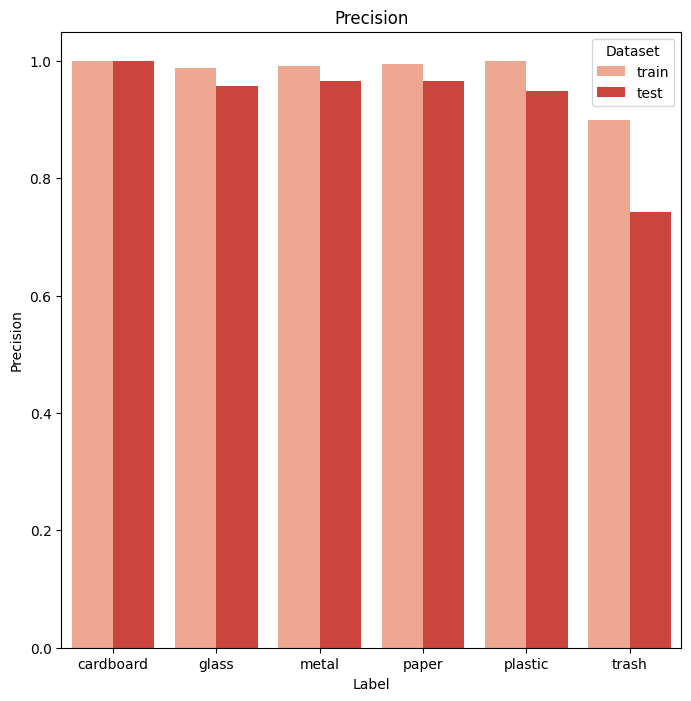

In [9]:
# Precision
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import seaborn as sns
import pandas as pd

train_prec = precision_score(train_preds['label'], train_preds['pred'], average=None)
test_prec = precision_score(test_preds['label'], test_preds['pred'], average=None)
df = pd.DataFrame({'label': labels, 'train': train_prec, 'test': test_prec})
dfm = pd.melt(df, id_vars=['label'], value_vars=['train', 'test'])

fig, ax = plt.subplots(figsize=(8, 8))
sns.barplot(x='label', y='value', hue='variable', data=dfm, ax=ax, palette="Reds")
ax.set_title("Precision")
ax.set_xlabel("Label")
ax.set_ylabel("Precision")
ax.legend(title="Dataset")
plt.show()

# Export precision
df.to_csv(f"eval/precision-{model_name}.csv")

# Export plot
fig.savefig(f"eval/precision-{model_name}.png", dpi=300)

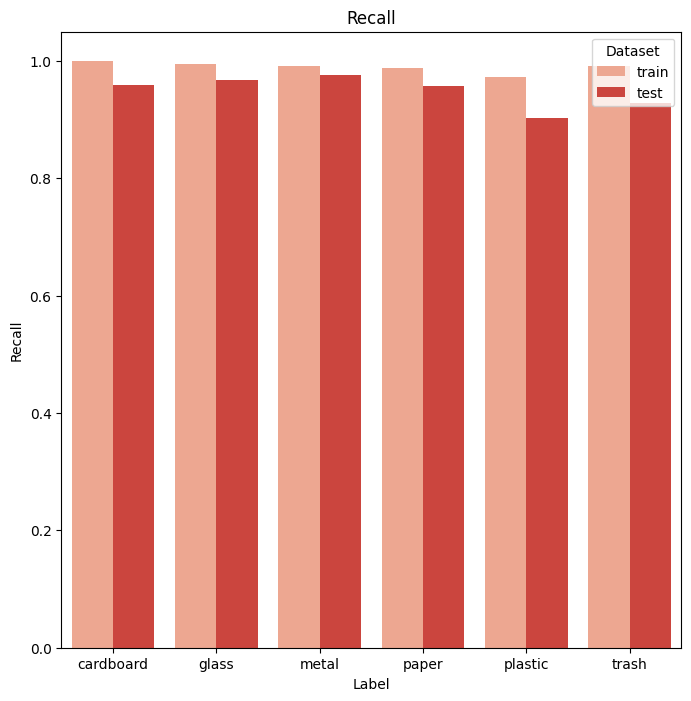

In [10]:
# Recall
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import seaborn as sns

train_rec = recall_score(train_preds['label'], train_preds['pred'], average=None)
test_rec = recall_score(test_preds['label'], test_preds['pred'], average=None)
df = pd.DataFrame({'label': labels, 'train': train_rec, 'test': test_rec})
dfm = pd.melt(df, id_vars=['label'], value_vars=['train', 'test'])

fig, ax = plt.subplots(figsize=(8, 8))
sns.barplot(x='label', y='value', hue='variable', data=dfm, ax=ax, palette="Reds")
ax.set_title("Recall")
ax.set_xlabel("Label")
ax.set_ylabel("Recall")
ax.legend(title="Dataset")
plt.show()

# Export recall
df.to_csv(f"eval/recall-{model_name}.csv")

# Export plot
fig.savefig(f"eval/recall-{model_name}.png", dpi=300)